In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.random import default_rng
rng = default_rng()
%matplotlib inline

In [2]:
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve


def Finite_difference_method(r,sigma,K,T,lambda_,Nx,Nt,x_min,x_max,max_iter):

    dx = (x_max - x_min) / Nx
    x = np.linspace(x_min, x_max, Nx+1)

    # Time discretization
    dt = T / Nt
    # Construct L_x matrix coefficients
    a = 0.5 * sigma**2 / dx**2 - (r - 0.5 * sigma**2) / (2 * dx)  # Lower diagonal
    b = -sigma**2 / dx**2 - r  # Main diagonal
    c = 0.5 * sigma**2 / dx**2 + (r - 0.5 * sigma**2) / (2 * dx)  # Upper diagonal

    # Banded matrix for efficient solving
    A_banded = np.zeros((3, Nx-1))
    A_banded[0, 1:] = c  # Upper diagonal
    A_banded[1, :] = 1/dt - b  # Main diagonal (implicit time step)
    A_banded[2, :-1] = a  # Lower diagonal

    # Initial condition (final condition for backward in time)
    eps = 1e-6  # Small value to prevent numerical issues
    h = np.maximum(K - np.exp(x), eps)  # Put option-like function
    nu = h.copy()

    # Newton iteration parameters
    tol = 1e-6
    max_iter = 50
    damping = 0.5  # Damping factor for Newton updates


    # Time stepping (backward in time)
    for n in reversed(range(Nt)):
        u_old = nu.copy()
        for k in range(max_iter):  # Newton iteration
            u_old = np.maximum(u_old, h - lambda_)  # Prevent instability
            
            # Compute f(u) (residual)
            f = (u_old[1:-1] - nu[1:-1]) / dt \
                - (a * u_old[:-2] + b * u_old[1:-1] + c * u_old[2:]) \
                + lambda_ * np.exp(-(u_old[1:-1] - h[1:-1]) / lambda_)

            # Compute the Jacobian J(u)
            d_main = 1 / dt - b - np.exp(-(u_old[1:-1] - h[1:-1]) / lambda_)  # Main diagonal
            d_lower = -a * np.ones(Nx-2)  # Lower diagonal
            d_upper = -c * np.ones(Nx-2)  # Upper diagonal
            
            # Construct sparse tridiagonal Jacobian matrix
            J = diags([d_lower, d_main, d_upper], offsets=[-1, 0, 1], format='csc')

            # Solve for du: J * du = -f
            du = spsolve(J, -f)

            # Apply damping to ensure stability
            u_old[1:-1] += damping * du

            # Check for NaN or convergence
            if np.any(np.isnan(u_old)):
                print("NaN encountered! Stopping.")
                break
            if np.linalg.norm(du) < tol:
                break

        nu = u_old.copy()
    

    return nu

In [3]:
# Paramètres : 

S0 = 40 
K = 1 
T = 1    
r = 0.06
sigma = 0.4
x_min, x_max = -1, 1  # Domain fo
N = 10  
dt = T / N  
Nx = 100        # Number of space steps
Nt = 100  
M = int(2**6) 
max_iter = 100
lambda_ = 0.005 

In [4]:
lambda_values = [0.1,0.05,0.01,0.001]
x = np.linspace(x_min, x_max, Nx+1)

U_values = np.zeros((len(lambda_values),len(x)))

for k,lda in enumerate(lambda_values) : 

    U_values[k] = Finite_difference_method(r,sigma,K,T,lda,Nx,Nt,x_min,x_max,max_iter)

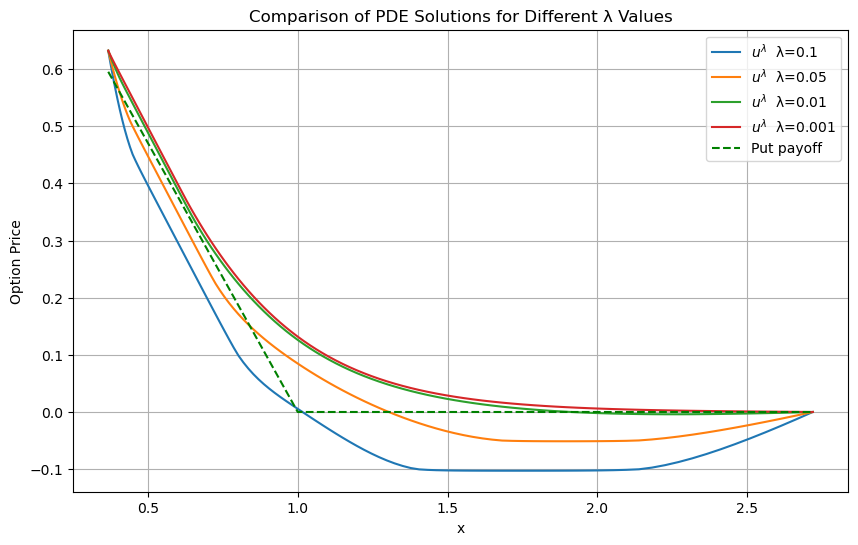

In [5]:
# Plot results

plt.figure(figsize=(10, 6))
for k, lda in enumerate(lambda_values):
    plt.plot(np.exp(x), U_values[k], label=fr'$u^λ$  λ={lda}')

# Plot American option price
plt.plot(np.exp(x),np.exp(-r*T)*np.maximum(K-np.exp(x),0), label = 'Put payoff', linestyle='dashed',color = 'Green')

plt.xlabel('x')
plt.ylabel('Option Price')
plt.title('Comparison of PDE Solutions for Different λ Values')
plt.legend()
plt.grid()
plt.show()